In [1]:
from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
from causalnex.structure.notears import from_pandas
# from causalnex.utils.network_utils import get_markov_blanket
from causalnex.structure.notears import from_pandas, from_pandas_lasso
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.discretiser.discretiser_strategy import ( DecisionTreeSupervisedDiscretiserMethod )

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
from IPython.display import Markdown, display, Image, display_html

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../scripts/')
from datacleaner import DataCleaner
from utils import Utils
from plotter import Plotter
from scipy.stats import skew

/home/teddy/anaconda3/envs/causal/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
utils = Utils()
plotter = Plotter()
cleaner = DataCleaner()


Load Data


In [3]:
data = utils.load_data('../data/data.csv')


In [4]:
features = ['diagnosis', 'perimeter_worst', 'area_worst', 'radius_worst', 'concave points_worst', 'concave points_mean', 'perimeter_mean', 'area_mean', 'radius_mean', 'area_se', 'concavity_mean', 'concavity_worst', 'perimeter_se', 'radius_se', 'compactness_worst', 'compactness_mean', 'texture_worst', 'concave points_se', 'smoothness_worst', 'texture_mean', 'symmetry_worst', 'concavity_se', 'smoothness_mean', 'symmetry_mean', 'compactness_se', 'fractal_dimension_worst', 'fractal_dimension_se', 'texture_se', 'fractal_dimension_mean', 'symmetry_se', 'smoothness_se']

In [5]:
x = data[features[:29]]
#Convert label encode categorical features
x['diagnosis'] = x['diagnosis'].apply(lambda x: 1 if x == "M" else 0)
x.head(5)

,diagnosis,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,...,texture_mean,symmetry_worst,concavity_se,smoothness_mean,symmetry_mean,compactness_se,fractal_dimension_worst,fractal_dimension_se,texture_se,fractal_dimension_mean
0,1,184.60,2019.0,25.38,0.2654,0.14710,122.80,1001.0,17.99,153.40,...,10.38,0.4601,0.05373,0.11840,0.2419,0.04904,0.11890,0.006193,0.9053,0.07871
1,1,158.80,1956.0,24.99,0.1860,0.07017,132.90,1326.0,20.57,74.08,...,17.77,0.2750,0.01860,0.08474,0.1812,0.01308,0.08902,0.003532,0.7339,0.05667
2,1,152.50,1709.0,23.57,0.2430,0.12790,130.00,1203.0,19.69,94.03,...,21.25,0.3613,0.03832,0.10960,0.2069,0.04006,0.08758,0.004571,0.7869,0.05999
3,1,98.87,567.7,14.91,0.2575,0.10520,77.58,386.1,11.42,27.23,...,20.38,0.6638,0.05661,0.14250,0.2597,0.07458,0.17300,0.009208,1.1560,0.09744
4,1,152.20,1575.0,22.54,0.1625,0.10430,135.10,1297.0,20.29,94.44,...,14.34,0.2364,0.05688,0.10030,0.1809,0.02461,0.07678,0.005115,0.7813,0.05883


In [6]:
features = x.iloc[:, 1:]
features

,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,concavity_mean,...,texture_mean,symmetry_worst,concavity_se,smoothness_mean,symmetry_mean,compactness_se,fractal_dimension_worst,fractal_dimension_se,texture_se,fractal_dimension_mean
0,184.60,2019.0,25.380,0.2654,0.14710,122.80,1001.0,17.99,153.40,0.30010,...,10.38,0.4601,0.05373,0.11840,0.2419,0.04904,0.11890,0.006193,0.9053,0.07871
1,158.80,1956.0,24.990,0.1860,0.07017,132.90,1326.0,20.57,74.08,0.08690,...,17.77,0.2750,0.01860,0.08474,0.1812,0.01308,0.08902,0.003532,0.7339,0.05667
2,152.50,1709.0,23.570,0.2430,0.12790,130.00,1203.0,19.69,94.03,0.19740,...,21.25,0.3613,0.03832,0.10960,0.2069,0.04006,0.08758,0.004571,0.7869,0.05999
3,98.87,567.7,14.910,0.2575,0.10520,77.58,386.1,11.42,27.23,0.24140,...,20.38,0.6638,0.05661,0.14250,0.2597,0.07458,0.17300,0.009208,1.1560,0.09744
4,152.20,1575.0,22.540,0.1625,0.10430,135.10,1297.0,20.29,94.44,0.19800,...,14.34,0.2364,0.05688,0.10030,0.1809,0.02461,0.07678,0.005115,0.7813,0.05883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,166.10,2027.0,25.450,0.2216,0.13890,142.00,1479.0,21.56,158.70,0.24390,...,22.39,0.2060,0.05198,0.11100,0.1726,0.02891,0.07115,0.004239,1.2560,0.05623
565,155.00,1731.0,23.690,0.1628,0.09791,131.20,1261.0,20.13,99.04,0.14400,...,28.25,0.2572,0.03950,0.09780,0.1752,0.02423,0.06637,0.002498,2.4630,0.05533
566,126.70,1124.0,18.980,0.1418,0.05302,108.30,858.1,16.60,48.55,0.09251,...,28.08,0.2218,0.04730,0.08455,0.1590,0.03731,0.07820,0.003892,1.0750,0.05648
567,184.60,1821.0,25.740,0.2650,0.15200,140.10,1265.0,20.60,86.22,0.35140,...,29.33,0.4087,0.07117,0.11780,0.2397,0.06158,0.12400,0.006185,1.5950,0.07016


# Normalize data

In [7]:
scaled_data = cleaner.min_max_scaler(features)

In [8]:
normalized_data = cleaner.normalizer(scaled_data)

In [9]:
normalized_data

,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,concavity_mean,...,texture_mean,symmetry_worst,concavity_se,smoothness_mean,symmetry_mean,compactness_se,fractal_dimension_worst,fractal_dimension_se,texture_se,fractal_dimension_mean
0,0.241534,0.162886,0.224354,0.329615,0.264231,0.197325,0.131456,0.188308,0.098958,0.254121,...,0.008189,0.216290,0.049037,0.214588,0.248058,0.126999,0.151381,0.066153,0.043539,0.218840
1,0.295233,0.238024,0.331922,0.349573,0.190740,0.336779,0.274326,0.351744,0.068725,0.111356,...,0.149074,0.127753,0.025688,0.158539,0.207716,0.044477,0.121895,0.049829,0.045169,0.077291
2,0.225628,0.166194,0.246904,0.370566,0.282095,0.264370,0.199435,0.266922,0.072299,0.205246,...,0.173184,0.179150,0.042942,0.228232,0.226141,0.126009,0.094714,0.056361,0.041848,0.093744
3,0.081340,0.031683,0.083687,0.298229,0.176219,0.078696,0.034682,0.070806,0.012859,0.190624,...,0.121613,0.337028,0.048180,0.273437,0.261622,0.183078,0.260762,0.096796,0.059275,0.337028
4,0.263457,0.177514,0.270107,0.290207,0.269404,0.327919,0.254280,0.327351,0.085067,0.241095,...,0.081372,0.081852,0.074647,0.223651,0.196591,0.087266,0.074106,0.075771,0.048365,0.097087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.247335,0.194315,0.267550,0.326895,0.296350,0.291332,0.243177,0.296197,0.121789,0.245312,...,0.184077,0.041886,0.056347,0.226203,0.144391,0.085946,0.045360,0.049596,0.084985,0.056688
565,0.250228,0.182505,0.269329,0.268751,0.233769,0.290169,0.227711,0.298953,0.082760,0.162079,...,0.301194,0.095357,0.047917,0.195892,0.167892,0.079294,0.035700,0.026607,0.223248,0.054332
566,0.231798,0.140764,0.239820,0.297281,0.160767,0.271965,0.184925,0.277738,0.047571,0.132236,...,0.379002,0.078529,0.072870,0.175802,0.163303,0.160634,0.092676,0.063172,0.096376,0.083776
567,0.218187,0.131254,0.206849,0.297306,0.246641,0.217282,0.155309,0.210434,0.048428,0.268799,...,0.216620,0.162304,0.058675,0.192077,0.220453,0.145471,0.147670,0.059669,0.089094,0.138896


In [10]:
normalized_data.insert(loc=0, column='diagnosis', value=x['diagnosis'])

In [11]:
%%time
sm = from_pandas(normalized_data.iloc[:, :9], tabu_parent_nodes=['diagnosis'],)

CPU times: user 59.4 s, sys: 50.3 s, total: 1min 49s
Wall time: 12.4 s


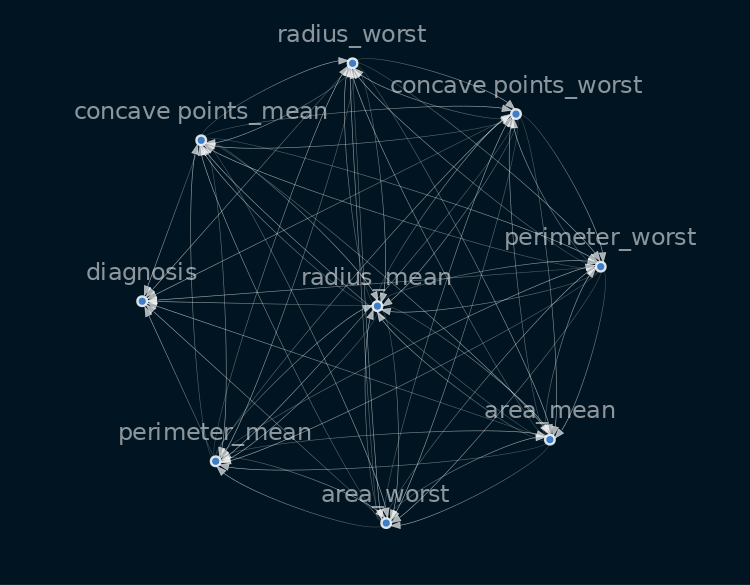

In [13]:
viz = plot_structure(
      sm,
      graph_attributes={"scale": "2.0", 'size': 2.5},
      all_node_attributes=NODE_STYLE.WEAK,
      all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [14]:
def vis_structure(s):
    plot_structure(
      s,
      graph_attributes={"scale": "2.0", 'size': 2.5},
      all_node_attributes=NODE_STYLE.WEAK,
      all_edge_attributes=EDGE_STYLE.WEAK)
    return Image(viz.draw(format='png'))

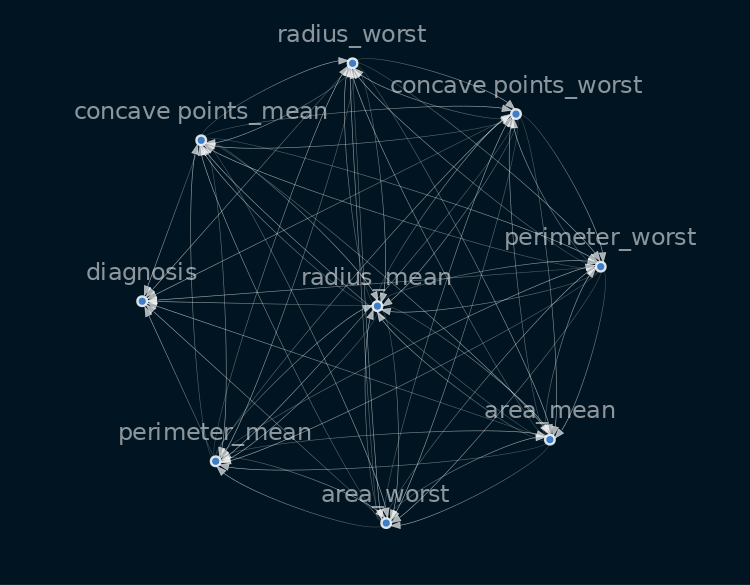

In [15]:
sm.remove_edges_below_threshold(0.8)
vis_structure(sm)

## Causal Graph Stability

In [16]:
x_selected = normalized_data.iloc[:, :10]

## 50%

In [17]:
portion = int(x_selected.shape[0] *.5)
x_portion = x_selected.head(portion)

CPU times: user 1min 31s, sys: 1min 19s, total: 2min 51s
Wall time: 17.6 s


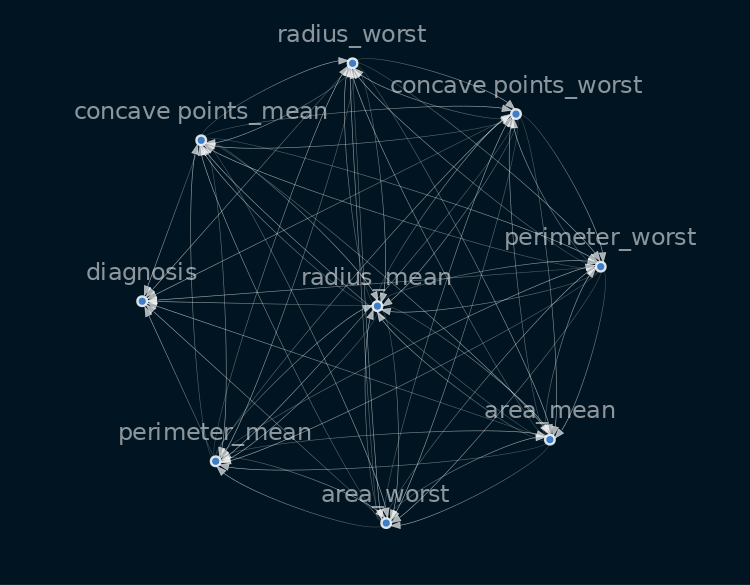

In [19]:
%%time
sm1 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm1.remove_edges_below_threshold(0.8)
sm1 = sm1.get_largest_subgraph()
vis_structure(sm1)

In [20]:
print(sm1.edges)

[('perimeter_worst', 'diagnosis'), ('perimeter_worst', 'radius_worst'), ('perimeter_worst', 'concave points_worst'), ('perimeter_worst', 'concave points_mean'), ('area_worst', 'diagnosis'), ('area_worst', 'perimeter_worst'), ('area_worst', 'concave points_worst'), ('radius_worst', 'diagnosis'), ('radius_worst', 'concave points_worst'), ('radius_worst', 'concave points_mean'), ('concave points_mean', 'diagnosis'), ('concave points_mean', 'concave points_worst'), ('perimeter_mean', 'diagnosis'), ('perimeter_mean', 'concave points_mean'), ('perimeter_mean', 'radius_mean'), ('area_mean', 'diagnosis'), ('area_mean', 'perimeter_mean'), ('radius_mean', 'diagnosis'), ('radius_mean', 'concave points_mean'), ('area_se', 'area_worst')]


## 60%

In [21]:
portion = int(x_selected.shape[0]*.6)
x_portion = x_selected.head(portion)

CPU times: user 1min 43s, sys: 1min 30s, total: 3min 14s
Wall time: 19.9 s


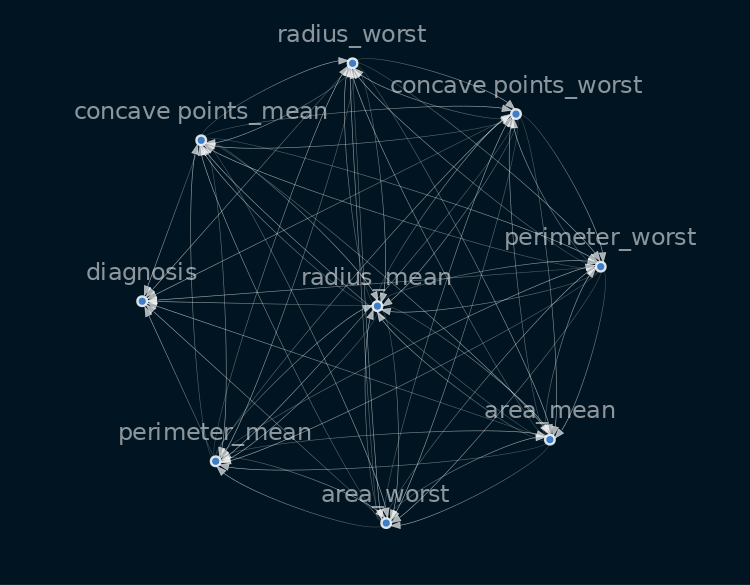

In [22]:
%%time
sm2 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm2.remove_edges_below_threshold(0.8)
sm2 = sm2.get_largest_subgraph()
vis_structure(sm2)

## Compute Jaccarand similarity

In [23]:
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)), 3)

In [24]:
jaccard_similarity(sm1.edges, sm2.edges)

0.952

## 70%

In [25]:
portion = int(x_selected.shape[0]*.7)
x_portion = x_selected.head(portion)

CPU times: user 1min 54s, sys: 1min 43s, total: 3min 37s
Wall time: 22.3 s


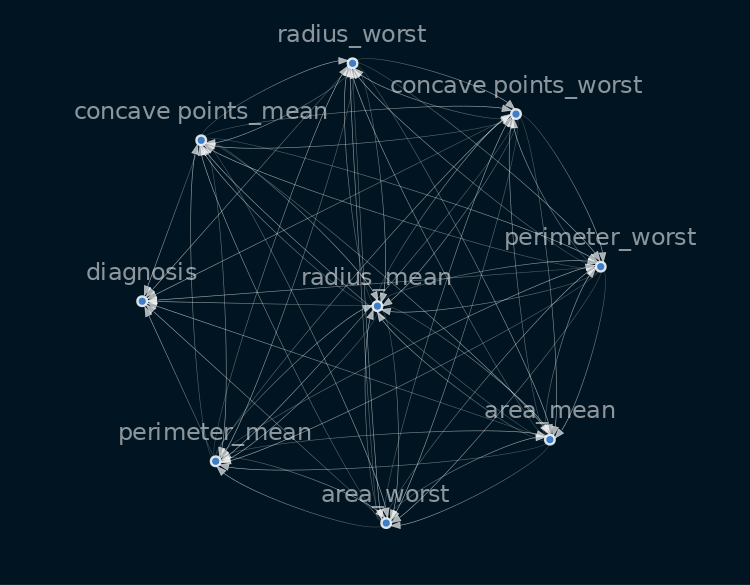

In [26]:
%%time
sm3 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm3.remove_edges_below_threshold(0.8)
sm3 = sm3.get_largest_subgraph()
vis_structure(sm3)

In [27]:
jaccard_similarity(sm2.edges, sm3.edges)

0.818

## 80%

In [28]:
portion = int(x_selected.shape[0] * .8)
x_portion = x_selected.head(portion)

CPU times: user 1min 44s, sys: 1min 31s, total: 3min 15s
Wall time: 20.2 s


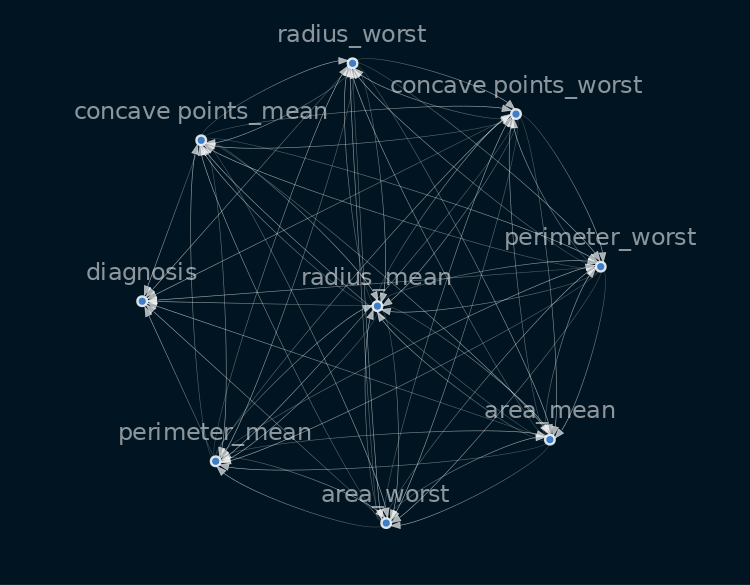

In [29]:
%%time
sm4 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm4.remove_edges_below_threshold(0.8)
sm4 = sm4.get_largest_subgraph()
vis_structure(sm4)

In [30]:
jaccard_similarity(sm3.edges, sm4.edges)

1.0

## 90%

In [31]:
portion = int(x_selected.shape[0] * .9)
x_portion = x_selected.head(portion)

CPU times: user 1min 42s, sys: 1min 31s, total: 3min 14s
Wall time: 20.1 s


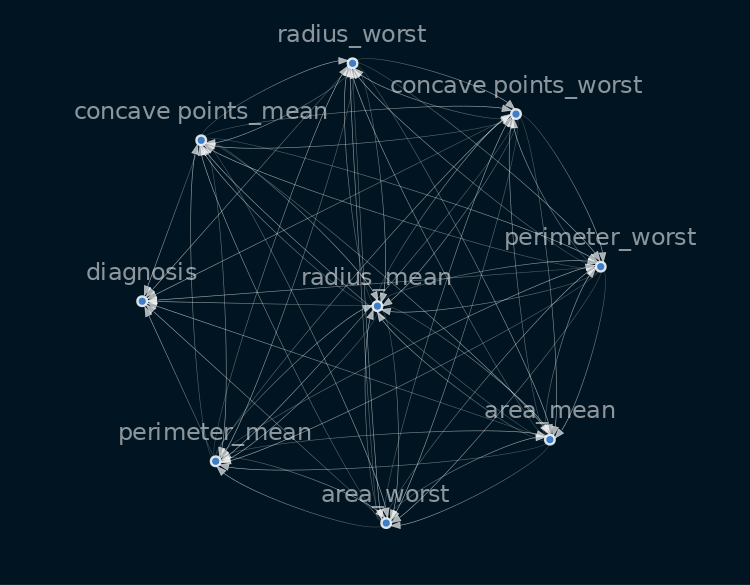

In [32]:
%%time
sm5 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm5.remove_edges_below_threshold(0.8)
sm5 = sm5.get_largest_subgraph()
vis_structure(sm5)

In [33]:
jaccard_similarity(sm5.edges, sm4.edges)

0.947

## 100%

CPU times: user 1min 56s, sys: 1min 44s, total: 3min 40s
Wall time: 22.8 s


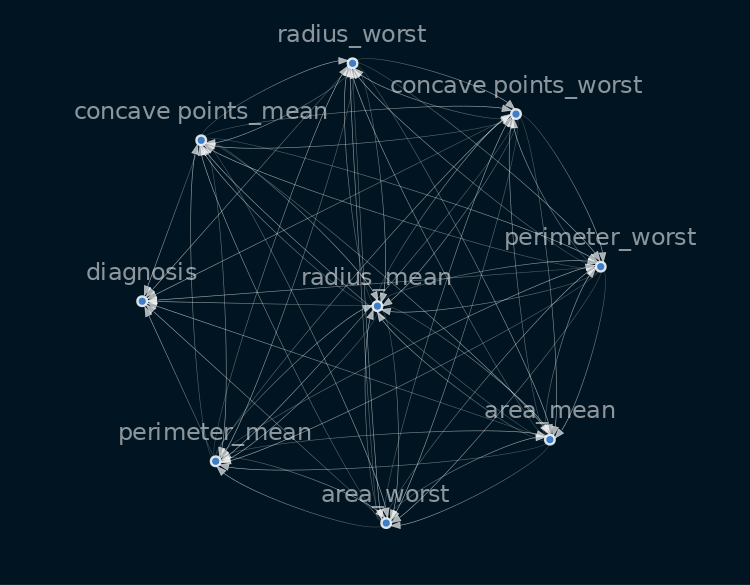

In [34]:
%%time
sm = from_pandas(x_selected, tabu_parent_nodes=['diagnosis'],)
sm.remove_edges_below_threshold(0.8)
sm = sm.get_largest_subgraph()
vis_structure(sm)

In [35]:
jaccard_similarity(sm.edges, sm5.edges)

0.947